In [244]:
#setup 
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
!pip install scikit-learn
import sklearn

mpl.rcParams['figure.figsize'] = (4, 3)
mpl.rcParams['axes.grid'] = False


In [245]:
new_table = pd.read_csv('https://raw.githubusercontent.com/giobbu/App_Traff_Forecast_DeapLearn/master/data/Flow_BEL_street_30min.csv')

In [246]:
# this source: 
# the https://www.kaggle.com/code/giobbu/seasonal-persistence-model/notebook#Results-Comparison-between-Seasonal-model-(baseline)-and-LSTM-encoder-decoder-model
# selects the roads that have an average traffic flow of 10 or larger, we also do this, this code is from the notebook listed above 

table_index = new_table.iloc[:,1:]
ALL_STREETS = list(table_index.columns.values)

mean_flow =[]
new_street=[]

mean_value = 20

for street in ALL_STREETS:
    
    single_street=table_index[street]
    mean = np.mean(single_street)
    mean_flow.append(mean)
    new_street.append(street)
    
    
df_mean_flow = pd.DataFrame({'street_index':new_street, 'mean_flow': mean_flow})
print('')
print(df_mean_flow.head())
print('')

STREETS = df_mean_flow[(df_mean_flow['mean_flow'] >= mean_value)] 
STREETS = STREETS.sort_values(by=['street_index'])
STREETS = list(STREETS.street_index)

keys_dim = 1683
keys_dim_time = 1686

print('considering a average traffic flow of ' + str(mean_value)+' per street')
print('')
print('mean traffic flow '+str(mean_value)+ ' ---> number of street segments: ' + str(len(STREETS)))


  street_index  mean_flow
0          0.0   4.048023
1          1.0  16.350282
2          2.0   6.511299
3          3.0   7.681850
4          4.0   9.484463

considering a average traffic flow of 20 per street

mean traffic flow 20 ---> number of street segments: 1683


In [247]:
new_table['datetime'] = pd.to_datetime(new_table['datetime'])

C:\Users\Lucia\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


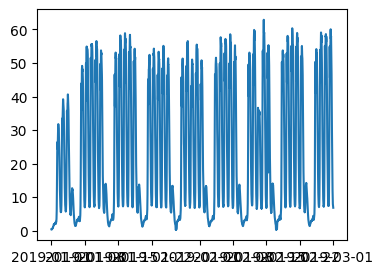

In [248]:
plt.plot(new_table['datetime'],new_table.mean(axis = 1))

In [249]:
from tensorflow.python.ops.gen_array_ops import fake_quant_with_min_max_vars_per_channel
#we need to create "windows" in the data --> 
#X: input tensor : use a window of size s, lets say 5, as X
#Y: output vector : traffic for hour six predicted based on the previous window 

#this is the window function for multiple input features and multiple output pairs
#what's the difference between df_to_x_y2 and df_to_x_y --> the first one is just for one input vector (ie the data from one street) this 
#version accepts many columns of data (all the street values and the transformed time data)
def df_to_x_y2(positional_data,non_positional, window_size): 
  #df_as_np = df.to_numpy()
  print(positional_data.shape)
  print(non_positional.shape)
  X = []
  Y = []
  for i in range((len(positional_data))-window_size-1):
    row = [r for r in positional_data[i:i+window_size]]
    
    #The line below makes the last value in the batch 0 (relative to what we are predicting, 
    #traffic flow rate, the positional information is still encoded )
    row.append(positional_data[i+window_size+1] - non_positional[i+window_size+1]) 
    X.append(row)
    
    label = [non_positional[i+window_size][0:]] 
    Y.append(label)
  return np.array(X), np.array(Y)

In [250]:
#this is for transforming datetime to recognizable inputs 
#sin and cos transformation for hour of the day 
df = new_table
df = df[STREETS + ['datetime']] 
 #this removes all of the streets with aveage flow <10 

df.head()

time = df['datetime'].to_numpy()

In [251]:
def positional_encoding(df):
  import datetime as dt
  from sklearn.preprocessing import MinMaxScaler
  df = pd.Series(df)
  hour = df.dt.hour.to_numpy().astype('float32')
  hour_sin = np.sin(hour*2* np.pi/23)
  hour_cos = np.cos(hour*2* np.pi/23)
  
  day_of_week = df.dt.dayofweek.to_numpy()
  day_of_week_scaler = MinMaxScaler(feature_range=(-1, 1))
  day_of_week = day_of_week.reshape(-1, 1)
  day_of_week = day_of_week_scaler.fit_transform(day_of_week)
  day_of_week = day_of_week[:,0]
  
  pos_encoding_val = hour_sin + hour_cos + day_of_week
  pos_encoding_val = pos_encoding_val.reshape(-1,1)
  final_scaler = MinMaxScaler(feature_range=(0,1))
  pos_encoding_val = final_scaler.fit_transform(pos_encoding_val)
  return pos_encoding_val
  

In [252]:
#test positoinal_encoding function 
positional_encoding(time)

array([[0.56847003],
       [0.56847003],
       [0.61674907],
       ...,
       [0.64311181],
       [0.70677715],
       [0.70677715]])

In [253]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, date_time_info,time_weight):
    super().__init__()
    from sklearn.preprocessing import MinMaxScaler
    self.time_weight = time_weight
    self.scaler = MinMaxScaler(feature_range=(0,1))
    self.pos_encoding = positional_encoding(date_time_info)

  def call(self, x):
    print(x.shape)
    print(type(x))
    print(x)
    length = tf.shape(x)[1]
    x = self.scaler.fit_transform(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    print(self.pos_encoding.shape)
    x_positioned = np.add(x*(1-self.time_weight), (self.time_weight * self.pos_encoding))
    print(x.shape)
    x_final,y_final= df_to_x_y2(x_positioned,x,window_size=12) 
    x_final = tf.constant(x_final)
    y_final = tf.constant(y_final)
    return x_final,y_final

In [254]:
#testing the positional embedding class 
positional_em = PositionalEmbedding(time,0.4)
positional_em2 = PositionalEmbedding(time,0)

print('shape1',positional_em(df[STREETS].to_numpy())[0][0])
print('shape2',positional_em2(df[STREETS].to_numpy())[0][0])

x1_df = df[STREETS + ['datetime']].to_numpy()

(2832, 1683)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[ 2.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  1.  1.  0.]
 [ 3.  1.  0. ...  1.  0.  0.]
 ...
 [31. 14.  4. ... 19.  8. 13.]
 [29. 16.  1. ... 16.  6. 27.]
 [21. 27.  6. ... 14.  4. 15.]], shape=(2832, 1683), dtype=float32)
(2832, 1)
(2832, 1683)
(2832, 1683)
(2832, 1683)
shape1 tf.Tensor(
[[0.23351046 0.22738801 0.22738801 ... 0.22738801 0.22738801 0.22738801]
 [0.23044924 0.22738801 0.22738801 ... 0.22999671 0.23538801 0.22738801]
 [0.2558833  0.25038061 0.24669963 ... 0.24930832 0.24669963 0.24669963]
 ...
 [0.2455972  0.24621695 0.24711613 ... 0.24514467 0.25053597 0.24474186]
 [0.24253597 0.24253597 0.24711613 ... 0.24253597 0.25053597 0.24694774]
 [0.21949069 0.21416954 0.2215315  ... 0.21805324 0.2215315  0.2215315 ]], shape=(13, 1683), dtype=float64)
(2832, 1683)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[ 2.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  1.  1.  0.]
 [ 3.  1.

In [255]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [256]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [257]:
#in globalself attention, we are comparing every token to iteself within the same sequence of tokens, here the query and value are both = x
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [258]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [259]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [260]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.causal_self_attention = CausalSelfAttention(
      num_heads=num_heads,
      key_dim=d_model,
      dropout=dropout_rate
    )

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    print('eh',x.shape)
    x = self.self_attention(x)
    print(x.shape)
    x = self.causal_self_attention(x)
    x = self.ffn(x)
    return x

In [261]:
x1_df_test = x1_df[0:336]
x1_df_test_time = x1_df_test[:,-1]
x1_test_data = df[STREETS][0:336].to_numpy()
print()
positional_em = PositionalEmbedding(x1_df_test_time,0.4)
x1_test, y1_test = positional_em(x1_test_data)
print(x1_test.shape)


(336, 1683)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[ 2.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  1.  1.  0.]
 [ 3.  1.  0. ...  1.  0.  0.]
 ...
 [46. 11.  8. ... 18.  7. 19.]
 [38.  6.  2. ... 15.  2. 11.]
 [21. 17.  5. ... 17.  7. 10.]], shape=(336, 1683), dtype=float32)
(336, 1)
(336, 1683)
(336, 1683)
(336, 1683)
(323, 13, 1683)


In [262]:
sample_encoder_layer = EncoderLayer(d_model=keys_dim, num_heads=8, dff=keys_dim)
encoder_test = positional_em(x1_test_data)[0]
print(encoder_test.shape)
print(sample_encoder_layer(encoder_test).shape)

(336, 1683)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[ 2.  0.  0. ...  0.  0.  0.]
 [ 1.  0.  0. ...  1.  1.  0.]
 [ 3.  1.  0. ...  1.  0.  0.]
 ...
 [46. 11.  8. ... 18.  7. 19.]
 [38.  6.  2. ... 15.  2. 11.]
 [21. 17.  5. ... 17.  7. 10.]], shape=(336, 1683), dtype=float32)
(336, 1)
(336, 1683)
(336, 1683)
(336, 1683)
(323, 13, 1683)
eh (323, 13, 1683)
(323, 13, 1683)
(323, 13, 1683)


In [263]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.enc_layers = [
        EncoderLayer(
                    d_model=d_model,
                     num_heads=num_heads,
                     dff=dff
                     )
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    print('try embedd',x.shape)

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      print()
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [264]:
sample_encoder = Encoder(num_layers=2,
                         d_model=keys_dim,
                         num_heads=5,
                         dff=keys_dim
                         )

sample_encoder_output = sample_encoder(encoder_test, training=False)

# Print the shape.
print(encoder_test.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

try embedd (323, 13, 1683)

eh (323, 13, 1683)
(323, 13, 1683)

eh (323, 13, 1683)
(323, 13, 1683)
(323, 13, 1683)
(323, 13, 1683)


In [265]:
#encoder only transformer 
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           dropout_rate=dropout_rate)
    #flattening before the final layer 
    self.flatten = tf.keras.layers.Flatten()
    self.final_layer = tf.keras.layers.Dense(d_model)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    print('input_shape',inputs.shape)
    x = inputs
    x = self.encoder(x)  # (batch_size, target_len, d_model)
    

    # Final linear layer output.
    x = self.flatten(x)
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    

    # Return the final output and the attention weights.
    return logits

In [266]:
num_layers = 2
d_model = keys_dim
dff = keys_dim
num_heads = 5
dropout_rate = 0.1



In [267]:
tf.shape(x_test).numpy()[0]

270

In [268]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
 
    dropout_rate=dropout_rate)




In [269]:
res = transformer(x_val)
res.shape


input_shape (270, 13, 1683)
try embedd (270, 13, 1683)

eh (270, 13, 1683)
(270, 13, 1683)

eh (270, 13, 1683)
(270, 13, 1683)


TensorShape([270, 1683])

In [270]:
res

<tf.Tensor: shape=(270, 1683), dtype=float32, numpy=
array([[ 1.3493625 , -0.2528943 ,  0.7292839 , ...,  0.08592357,
        -1.3404833 ,  1.2963028 ],
       [ 2.139405  , -0.94322336,  0.06880999, ...,  0.28826323,
        -2.0108783 ,  0.38733715],
       [ 0.7447667 , -1.0659695 ,  1.3664515 , ..., -1.1704389 ,
        -1.3447839 ,  1.4582857 ],
       ...,
       [-0.61172146, -1.380743  ,  0.14974596, ..., -0.31717938,
        -1.8143109 , -2.6408339 ],
       [ 0.30303782, -0.7574044 ,  0.80890965, ..., -0.928675  ,
        -0.45194203, -2.7888186 ],
       [-0.34451622, -1.7593838 ,  0.47112876, ...,  0.36106247,
        -1.7563726 , -1.7742918 ]], dtype=float32)>

In [271]:
print(x1_df.shape)
length = 2832
#80, 10, 10 split from train val test 
val_step = int(0.1 * length) * 2
test_step = int(0.1 * length)

val_s = length - val_step
test_s = length - test_step

x_train = x1_df[:val_s]
x_val = x1_df[val_s:test_s]
x_test= x1_df[test_s:]



print(x_test.shape)

(2832, 1684)
(283, 1684)


In [272]:
#positionally encode and divide all data sets into batches 
train_time = x_train[:,-1]
train_feat = x_train[:,:-1]
val_time = x_val[:,-1]
val_feat = x_val[:,:-1]
test_time = x_test[:,-1]
test_feat = x_test[:,:-1]
print(x_test.shape)
print(x_val.shape)
print(test_time.shape)

train_pos_enc = PositionalEmbedding(train_time,0.1)
val_pos_enc = PositionalEmbedding(val_time,0.1)
test_pos_enc = PositionalEmbedding(test_time,0.1)


x_train,y_train = train_pos_enc(np.asarray(train_feat).astype('float32'))
x_val,y_val = val_pos_enc(np.asarray(val_feat).astype('float32'))
x_test,y_test = test_pos_enc(np.asarray(test_feat).astype('float32'))


(283, 1684)
(283, 1684)
(283,)
(2266, 1683)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[2. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 1. 1. 0.]
 [3. 1. 0. ... 1. 0. 0.]
 ...
 [5. 1. 0. ... 2. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 0. 0. 1.]], shape=(2266, 1683), dtype=float32)
(2266, 1)
(2266, 1683)
(2266, 1683)
(2266, 1683)
(283, 1683)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[ 2.  1.  0. ...  0.  0.  2.]
 [ 2.  1.  0. ...  3.  1.  8.]
 [ 1.  2.  1. ...  5.  0.  8.]
 ...
 [19. 11.  1. ... 19.  1. 12.]
 [26. 16.  2. ...  4.  1. 14.]
 [29. 11.  4. ... 11.  0. 11.]], shape=(283, 1683), dtype=float32)
(283, 1)
(283, 1683)
(283, 1683)
(283, 1683)
(283, 1683)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[31. 23.  1. ... 13.  8. 17.]
 [48. 20.  5. ... 17.  3. 20.]
 [47. 27.  6. ...  7.  2. 20.]
 ...
 [31. 14.  4. ... 19.  8. 13.]
 [29. 16.  1. ... 16.  6. 27.]
 [21. 27.  6. ... 14.  4. 15.]], shape=(283, 1683), dtype=float3

tf.Tensor([0.00763359], shape=(1,), dtype=float64)
tf.Tensor(
[0.056847   0.056847   0.06167491 0.06167491 0.06460611 0.06460611
 0.0654232  0.0654232  0.06406561 0.06406561 0.06750422 0.06750422
 0.05538288], shape=(13,), dtype=float64)


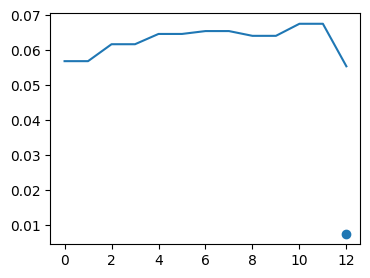

In [273]:
plt.plot(x_train[0,:,2])

plt.scatter(12,y_train[0,:,2])
print(y_train[0,:,2])
print(x_train[0,:,2])

In [274]:
train_dataloader = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(64)
val_dataloader = tf.data.Dataset.from_tensor_slices((x_val, y_val)).shuffle(10000).batch(64)
test_dataloader = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(64)

train_batch_size = 2253
val_batch_size = 270
test_batch_size = 270

print(train_dataloader)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

<BatchDataset element_spec=(TensorSpec(shape=(None, 13, 1683), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1683), dtype=tf.float64, name=None))>


In [275]:
def evaluate(dataloader, model, log=False):
    
    for traffic_batch, labels_batch in dataloader:
        traffic = traffic_batch
        print(traffic.shape)
        predict_flow = model(traffic)
        mse = tf.keras.losses.MeanSquaredError()
        mse = mse(labels_batch,predict_flow ).numpy()
    
    return predict_flow

In [276]:

evaluate(test_dataloader,transformer)

(64, 13, 1683)
input_shape (64, 13, 1683)
try embedd (64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)
(64, 13, 1683)
input_shape (64, 13, 1683)
try embedd (64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)
(64, 13, 1683)
input_shape (64, 13, 1683)
try embedd (64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)
(64, 13, 1683)
input_shape (64, 13, 1683)
try embedd (64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)
(14, 13, 1683)
input_shape (14, 13, 1683)
try embedd (14, 13, 1683)

eh (14, 13, 1683)
(14, 13, 1683)

eh (14, 13, 1683)
(14, 13, 1683)


<tf.Tensor: shape=(14, 1683), dtype=float32, numpy=
array([[ 1.2822503 , -0.72675776,  1.1211731 , ...,  0.25685447,
        -2.2223048 , -1.8311831 ],
       [ 1.427353  , -0.8382702 , -0.40021935, ..., -0.46743992,
        -0.6046665 , -1.2413753 ],
       [ 1.8467939 , -0.2729177 , -0.48882994, ..., -0.4009493 ,
        -1.1264985 , -0.30569312],
       ...,
       [ 0.23431093, -0.08260667,  1.5720778 , ...,  0.22135569,
        -3.0732756 , -1.081479  ],
       [ 0.99259496, -3.033956  ,  1.521604  , ..., -1.3929875 ,
        -2.793061  , -0.55978096],
       [-0.09762865, -0.6336558 ,  0.17745526, ..., -0.3079939 ,
        -0.960426  , -0.59096956]], dtype=float32)>

In [277]:
def loss(y_true, y_pred):
    mse = tf.keras.losses.MeanSquaredError()
    y = mse(y_true, y_pred)
    return y_train

In [278]:
transformer.compile(optimizer=optimizer, 
                  loss = tf.keras.losses.MeanSquaredError(), 
                  metrics= [tf.keras.losses.MeanSquaredError()]) 

In [279]:
transformer.fit(train_dataloader,epochs = 5,validation_data = val_dataloader)

Epoch 1/5
input_shape (None, 13, 1683)
try embedd (None, 13, 1683)

eh (None, 13, 1683)
(None, 13, 1683)

eh (None, 13, 1683)
(None, 13, 1683)


ResourceExhaustedError: in user code:

    File "c:\Users\Lucia\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Lucia\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Lucia\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Lucia\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 997, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\Lucia\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 579, in minimize
        return self.apply_gradients(grads_and_vars, name=name)
    File "c:\Users\Lucia\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 695, in apply_gradients
        self._create_all_weights(var_list)
    File "c:\Users\Lucia\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 959, in _create_all_weights
        self._create_slots(var_list)
    File "c:\Users\Lucia\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\optimizers\optimizer_v2\adam.py", line 128, in _create_slots
        self.add_slot(var, "v")
    File "c:\Users\Lucia\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 1054, in add_slot
        initial_value=initial_value,
    File "c:\Users\Lucia\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\initializers\initializers_v2.py", line 171, in __call__
        return tf.zeros(shape, dtype)

    ResourceExhaustedError: {{function_node __wrapped__Fill_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[1683,5,1683] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Fill]


9/9 [==============================] - 5s 497ms/step


(270, 1, 1683)

In [ ]:
response = evaluate(test_dataloader,transformer)

(64, 13, 1683)
input_shape (64, 13, 1683)
try embedd (64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)
(64, 13, 1683)
input_shape (64, 13, 1683)
try embedd (64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)
(64, 13, 1683)
input_shape (64, 13, 1683)
try embedd (64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)
(64, 13, 1683)
input_shape (64, 13, 1683)
try embedd (64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)

eh (64, 13, 1683)
(64, 13, 1683)
(14, 13, 1683)
input_shape (14, 13, 1683)
try embedd (14, 13, 1683)

eh (14, 13, 1683)
(14, 13, 1683)

eh (14, 13, 1683)
(14, 13, 1683)


<tf.Tensor: shape=(1683,), dtype=float32, numpy=
array([0.5105652 , 0.769401  , 0.5133104 , ..., 0.7367399 , 0.24415182,
       0.23881918], dtype=float32)>

In [ ]:
res = transformer.predict(x_test)
res[0]

input_shape (None, 13, 1683)
try embedd (None, 13, 1683)

eh (None, 13, 1683)
(None, 13, 1683)

eh (None, 13, 1683)
(None, 13, 1683)
9/9 [==============================] - 30s 3s/step


array([ 0.9777408 ,  0.34883803,  0.18866953, ..., -0.12198821,
        0.47574732,  0.25731924], dtype=float32)

In [ ]:
res2 = tf.reduce_mean(res,1)

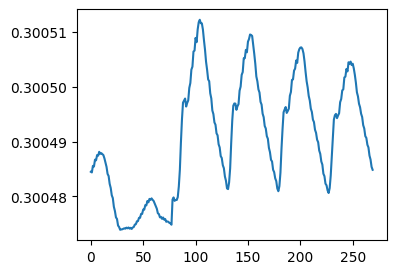

In [ ]:
plt.plot(res2)
#plt.plot(tf.reduce_mean(y_test,2))


In [ ]:
print(max(res2))
print(min(res2))

tf.Tensor(0.16782263, shape=(), dtype=float32)
tf.Tensor(0.1677308, shape=(), dtype=float32)
